In [146]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split

In [2]:
interactions = pd.read_csv("/kaggle/input/olx-jobs-interactions/interactions.csv")

# Ogarnięcie danych
## Usunięcie użytkowników z mala/duża ilością interakcji

In [158]:
def compute_quantiles(series, quantiles=np.arange(0.01, 1.01, 0.03)):
    return pd.DataFrame(
        [[quantile, series.quantile(quantile)] for quantile in quantiles],
        columns=["quantile", "value"],
    )

In [159]:
interactions_per_user = interactions.groupby("user").size()

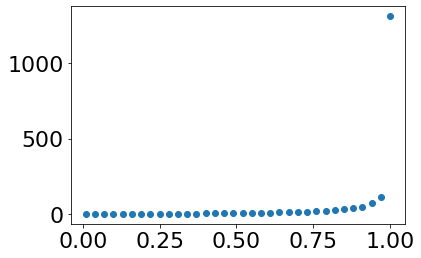

In [160]:
interaction_per_user_quantiles = compute_quantiles(interactions_per_user)
plt.scatter(interaction_per_user_quantiles['quantile'], interaction_per_user_quantiles['value'])
plt.show()

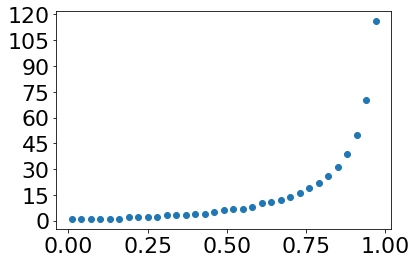

In [162]:
# Wykres po usunieciu ostatniej obs
plt.scatter(interaction_per_user_quantiles['quantile'][:-1], interaction_per_user_quantiles['value'][:-1])
plt.yticks(range(0, 121, 15))
plt.show()

In [163]:
lower_limit = interactions_per_user.quantile(0.63)  # wybieramy użytkowników z co najmniej 10 interakcjami
upper_limit = interactions_per_user.quantile(0.965)  # z maksymalnie 104 interakcjami - do ustalenia

filtered_int_per_us = interactions_per_user[(interactions_per_user >= lower_limit) & (interactions_per_user <= upper_limit)]

In [164]:
selected_users = [user for user in filtered_int_per_us.index]
df = interactions.query('user in @selected_users')

## Usunięcię outlierów z itemów

In [165]:
interactions_per_item = interactions.groupby("item").size()

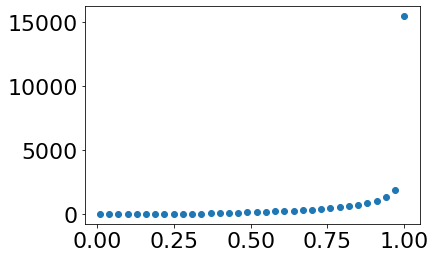

In [166]:
interaction_per_item_quantiles = compute_quantiles(interactions_per_item)
plt.scatter(interaction_per_item_quantiles['quantile'], interaction_per_item_quantiles['value'])
plt.show()

In [167]:
lower_limit = interactions_per_item.quantile(0.295)  # wybieramy itemy z co najmniej 9 wystąpieniami
upper_limit = interactions_per_item.quantile(0.92)  # z maksymalnie 1097 wystąpieniami - do ustalenia

filtered_int_per_item = interactions_per_item[(interactions_per_item >= lower_limit) & (interactions_per_item <= upper_limit)]

In [168]:
selected_items = [item for item in filtered_int_per_item.index]
df1 = df.query('item in @selected_items') # df1 - df z wybranymi uzytkownikami i itemami po usunieciu outlierow

In [169]:
df1

,user,item,event,timestamp
0,27901,56865,click,1581465600
1,124480,115662,click,1581465600
2,159509,5150,click,1581465600
7,395203,178160,click,1581465600
8,536650,93098,click,1581465600
...,...,...,...,...
65502190,2261445,37983,click,1582675199
65502196,2876233,90074,click,1582675199
65502197,3011254,90671,click,1582675199
65502198,3011612,62471,click,1582675199


# Teraz selekcja itemów oraz użytkowników z największą liczbą interakcji

In [170]:
# posortowana ilosc wystapien kazdego itemu
item_counts = df1['item'].value_counts().sort_values(ascending=False)

# indeksy najczesciej wystepujacych itemow
sel_items = item_counts.head(int(0.2 * len(item_counts))).index

# filtrowanie po itemach
df_filtered_items = df1.query('item in @sel_items')

In [171]:
# posrotowana ilosc interakcji odpowiadajacych uzytkownikom
users_interactions_ = df_filtered_items.groupby('user').size().sort_values(ascending=False)

# indeksy uzytkownikow z najwieksza liczba interakcji
sel_users = users_interactions_.head(int(0.2 * len(users_interactions_))).index

# ostateczny df
df_final = df_filtered_items.query('user in @sel_users')

In [172]:
df_final

,user,item,event,timestamp
15,1109423,22739,click,1581465600
23,1667483,165344,click,1581465600
47,3280353,84135,click,1581465600
58,753687,143922,click,1581465601
60,922990,180376,click,1581465601
...,...,...,...,...
65502093,1746022,13124,click,1582675197
65502113,639042,98234,click,1582675198
65502152,342487,132700,click,1582675199
65502162,762482,99230,click,1582675199


## Próbkowanie z tego zbioru, zeby go troche zmniejszyc

In [173]:
unique_users = df_final['user'].unique()

np.random.seed(42)
random_users = np.random.choice(unique_users, int(0.1 * len(unique_users)))

ostateczny_df = df_final.query('user in @random_users')

In [174]:
ostateczny_df

,user,item,event,timestamp
65,1078197,37638,contact_phone_click_1,1581465601
236,1747201,19006,click,1581465604
266,1078197,37638,contact_phone_click_2,1581465605
372,2611993,43416,click,1581465607
389,869034,71316,click,1581465608
...,...,...,...,...
65501352,2560292,57166,click,1582675178
65501460,2410223,3495,click,1582675181
65501859,1927384,156014,click,1582675191
65502002,1468288,134275,click,1582675195


## Podstawowe statystyki zbioru

In [175]:
n_users = ostateczny_df["user"].nunique()
n_items = ostateczny_df["item"].nunique()
n_interactions = ostateczny_df.shape[0]

interactions_per_user = ostateczny_df.groupby("user").size()
interactions_per_item = ostateczny_df.groupby("item").size()

print(f"We have {n_users} users, {n_items} items and {n_interactions} interactions.")
print(f"Data sparsity (% of missing entries) is {100 * (1- n_interactions / (n_users * n_items)):.2f}%.")
print(f"Average number of interactions per user is {interactions_per_user.mean():.2f} (standard deviation {interactions_per_user.std(ddof=0):.2f}).")
print(f"Average number of interactions per item is {interactions_per_item.mean():.2f} (standard deviation {interactions_per_item.std(ddof=0):.2f}).")

We have 21666 users, 23234 items and 424758 interactions.
Data sparsity (% of missing entries) is 99.92%.
Average number of interactions per user is 19.60 (standard deviation 6.57).
Average number of interactions per item is 18.28 (standard deviation 8.49).


## Wykresy

In [176]:
def plot_interactions_distribution(series, aggregation="user", ylabel="Users", bins=30):
    matplotlib.rcParams.update({"font.size": 22})
    series.plot.hist(bins=bins, rwidth=0.9, logy=True, figsize=(16, 9))
    plt.title(f"Number of interactions per {aggregation}")
    plt.xlabel("Interactions")
    plt.ylabel(ylabel)
    plt.grid(axis="y", alpha=0.5)

Interactions distribution per user:


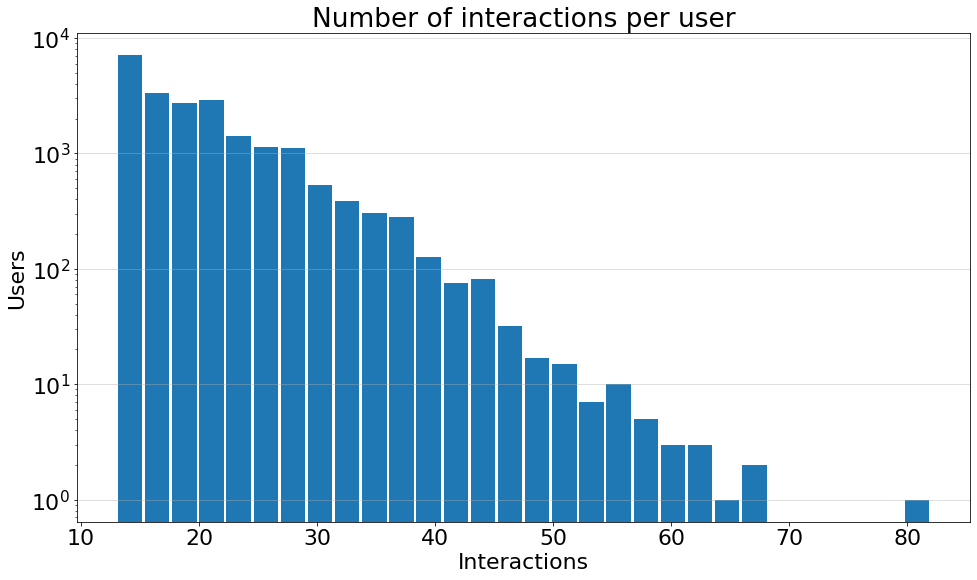

In [177]:
print("Interactions distribution per user:")
plot_interactions_distribution(interactions_per_user, "user", "Users")

Interactions distribution per item:


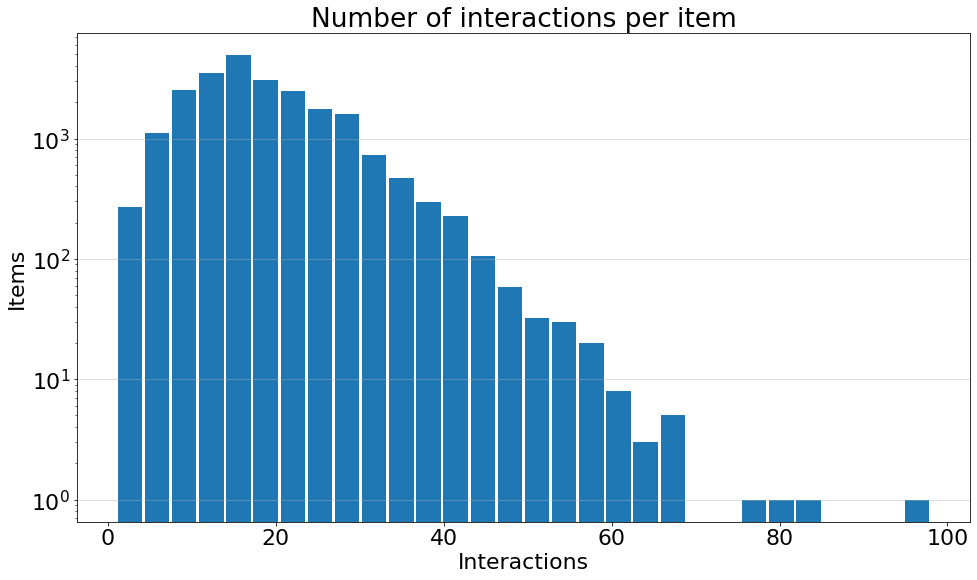

In [178]:
print("Interactions distribution per item:")
plot_interactions_distribution(interactions_per_item, "item", "Items")

## Interakcje w czasie

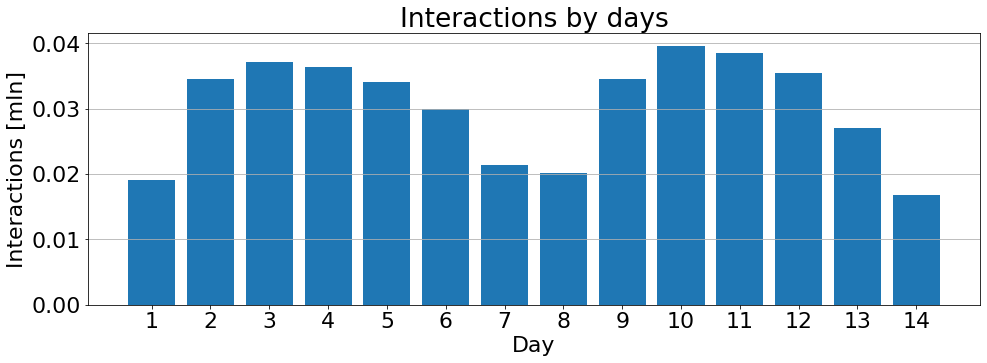

In [179]:
def unix_to_day(timestamps):
    min_timestamp = timestamps.min()
    seconds_in_day = 60*60*24
    return (timestamps - min_timestamp) // seconds_in_day + 1

def plot_interactions_over_time(series):
    freq = series.value_counts()
    labels, counts = freq.index, freq.values/10**6
    
    matplotlib.rcParams.update({"font.size": 22})
    plt.figure(figsize=(16,5))
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.title(f"Interactions by days")
    plt.xlabel("Day")
    plt.ylabel("Interactions [mln]")
    plt.grid(axis="y")

plot_interactions_over_time(unix_to_day(ostateczny_df["timestamp"]))

## Rozkład eventów

In [180]:
event_frequency = pd.DataFrame(
    ostateczny_df["event"].value_counts() / len(ostateczny_df)
).rename(columns={"event": "frequency"})

event_frequency["frequency"] = event_frequency["frequency"].apply(
    lambda x: f"{100*x:.2f}%"
)
event_frequency

,frequency
click,88.53%
bookmark,2.92%
contact_phone_click_1,2.86%
chat_click,2.34%
contact_chat,1.57%
contact_partner_click,0.92%
contact_phone_click_2,0.74%
contact_phone_click_3,0.13%


# Podział na zbiór testowy i treningowy

In [ ]:
# do przepisania 